In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import csv
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(file_path, chunk_size):
    """
    Loads time series data from a text file, creates overlapping sequences,
    and splits the data into training and testing sets.

    Args:
        file_path (str): Path to the text file containing the data.
        chunk_size (int): The number of time steps in each input sequence.
        test_size (float, optional): Proportion of data to use for testing (default: 0.2).
        shuffle (bool, optional): Whether to shuffle the data before splitting (default: False).

    Returns:
        X_train (numpy.ndarray): Training input sequences (3D array).
        X_test (numpy.ndarray): Testing input sequences (3D array).
        y_train (numpy.ndarray): Training target values (2D array).
        y_test (numpy.ndarray): Testing target values (2D array).
    """
    # Load data
    data = np.loadtxt(file_path, delimiter=',')  # Adjust delimiter if needed
    data = data.flatten()
    print(data)

    # Create overlapping sequences
    X, y = [], []
    for i in range(len(data) - chunk_size):
        X.append(data[i : i + chunk_size])
        y.append(data[i + chunk_size])
    X = np.array(X)
    y = np.array(y)

    print(f"Initial shape of X: {X.shape}")  # Debugging statement
    print(X)
    print(y)
    
    print(f"Initial shape of y: {y.shape}")  # Debugging statement

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    

    return X_train, X_test, y_train, y_test
file_path = r"D:\Studies\Summer 2024 research\small.tgz\small\fluorescence_iNet1_Size100_CC03inh.txt"
chunk_size = 10

X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path, chunk_size)



[ 0.052  0.14  -0.06  ...  0.073  0.011 -0.009]
Initial shape of X: (17949790, 10)
[[ 0.052  0.14  -0.06  ...  0.061  0.007 -0.04 ]
 [ 0.14  -0.06   0.004 ...  0.007 -0.04   0.147]
 [-0.06   0.004  0.024 ... -0.04   0.147  0.042]
 ...
 [-0.006 -0.015  0.018 ...  0.024  0.065  0.015]
 [-0.015  0.018  0.005 ...  0.065  0.015  0.073]
 [ 0.018  0.005  0.037 ...  0.015  0.073  0.011]]
[ 0.147  0.042 -0.007 ...  0.073  0.011 -0.009]
Initial shape of y: (17949790,)


224373/224373 ━━━━━━━━━━━━━━━━━━━━ 548s 2ms/step - loss: 0.0354
112187/112187 ━━━━━━━━━━━━━━━━━━━━ 120s 1ms/step - loss: 0.0333
Test Loss: 0.03466786816716194
Hidden state model created successfully.
112187/112187 ━━━━━━━━━━━━━━━━━━━━ 123s 1ms/step
Hidden states shape: (3589958, 10, 1)
Proceeding with plotting...
112187/112187 ━━━━━━━━━━━━━━━━━━━━ 127s 1ms/step
Predictions shape: (3589958, 10, 1)


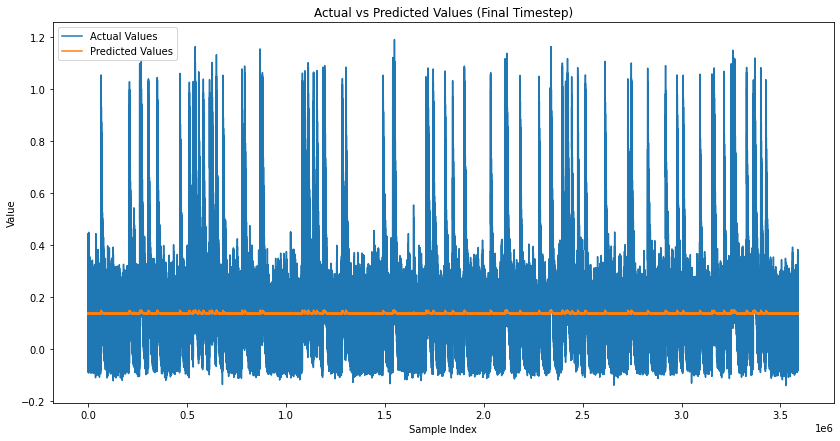

Unit indices are within bounds.
Sample indices are within bounds.


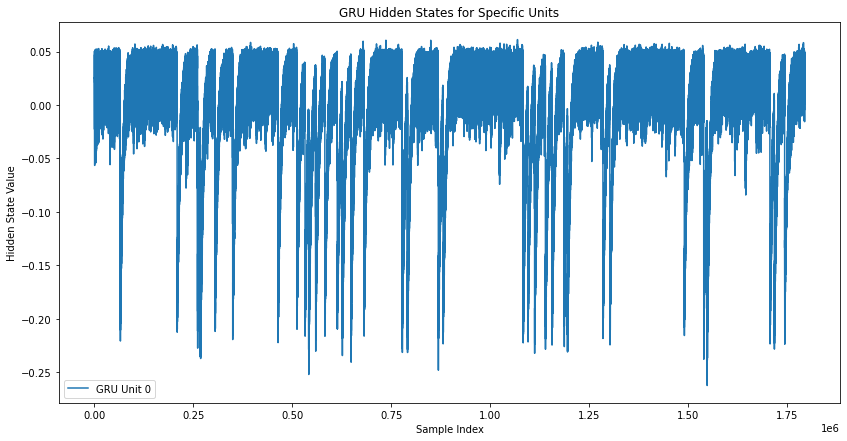

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Dense, Input
from keras import backend as K

# Clear previous models (if necessary)
K.clear_session()

# Reshape X_train and X_test if necessary
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # (input is 3D array)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the model with an explicit input layer
input_layer = Input(shape=(X_train.shape[1], 1))
gru_layer = GRU(units=1, return_sequences=True, name='gru_layer')(input_layer)
output_layer = Dense(units=1)(gru_layer)

# Create the full model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=64)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Create a separate model to get the GRU hidden states
try:
    hidden_state_model = Model(inputs=model.input, outputs=model.get_layer('gru_layer').output)
    print("Hidden state model created successfully.")
except Exception as e:
    print(f"Error creating hidden_state_model: {e}")
    hidden_state_model = None

# Get the hidden states from the GRU layer
hidden_states = None
if hidden_state_model is not None:
    try:
        hidden_states = hidden_state_model.predict(X_test)
        print(f"Hidden states shape: {hidden_states.shape}")
    except Exception as e:
        print(f"Error predicting hidden states: {e}")
        hidden_states = None

if hidden_states is not None:
    print("Proceeding with plotting...")
    
    # Make predictions using the main model
    y_pred = model.predict(X_test)
    print(f"Predictions shape: {y_pred.shape}")

    # Extract the final timestep predictions
    y_pred_last_timestep = y_pred[:, -1, 0]
    
    # Ensure y_test is also aligned for the comparison
    if len(y_test.shape) == 3:
        y_test_last_timestep = y_test[:, -1, 0]
    else:
        y_test_last_timestep = y_test

    # Plot the final predictions vs. actual values
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_last_timestep, label='Actual Values')
    plt.plot(y_pred_last_timestep, label='Predicted Values')
    plt.title('Actual vs Predicted Values (Final Timestep)')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Validate indices
    unit_indices = [0]  # Indices of the GRU units you want to plot
    sample_indices = range(0,1794980)  # Smaller sample range for plotting

    if max(unit_indices) < hidden_states.shape[2]:
        print("Unit indices are within bounds.")
    else:
        print("Unit indices are out of bounds.")

    if max(sample_indices) < hidden_states.shape[0]:
        print("Sample indices are within bounds.")
    else:
        print("Sample indices are out of bounds.")

    # Plot hidden states for specific GRU units
    plt.figure(figsize=(14, 7))
    for unit in unit_indices:
        plt.plot(hidden_states[sample_indices, -1, unit], label=f'GRU Unit {unit}')
    plt.title('GRU Hidden States for Specific Units')
    plt.xlabel('Sample Index')
    plt.ylabel('Hidden State Value')
    plt.legend()
    plt.show()

else:
    print("Skipping plotting because hidden_states were not generated.")


In [22]:
from sklearn.metrics import r2_score
import numpy as np

# Assuming y_test and y_pred are given with the shapes mentioned
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Extract the last timestep from y_pred
y_pred_last_timestep = y_pred[:, -1, 0]  # Shape becomes (3589958,)

# Now calculate the R² score
r2 = r2_score(y_test, y_pred_last_timestep)
print(f'R-squared (R²) Score: {r2}')



Shape of y_test: (3589958,)
Shape of y_pred: (3589958, 10, 1)
R-squared (R²) Score: 0.02762059245591819


In [33]:
# Extract weights from the GRU layer
gru_weights = model.layers[1].get_weights()  # Assume the GRU layer is the first layer

# Verify the number of elements and shapes in gru_weights
print(f"Number of elements in gru_weights: {len(gru_weights)}")
for i, weight in enumerate(gru_weights):
    print(f"Shape of gru_weights[{i}]: {weight.shape}")

# Determine the number of GRU units dynamically
num_units = gru_weights[0].shape[1] // 3  # Calculate the number of GRU units

# Extract W_h (kernel weights associated with new memory content)
W_h = gru_weights[0][:, 2 * num_units:]  # Slice the last third for new memory content

# Check the shape of W_h before saving
print(f"W_h shape: {W_h.shape}")

# Save W_h to a CSV file
weights_file = 'gru_W_h_weights.csv'
with open(weights_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(W_h)

print(f"GRU W_h weights saved to {weights_file}")

Number of elements in gru_weights: 3
Shape of gru_weights[0]: (1, 3)
Shape of gru_weights[1]: (1, 3)
Shape of gru_weights[2]: (2, 3)
W_h shape: (1, 1)
GRU W_h weights saved to gru_W_h_weights.csv


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Load and Prepare True Network Data
true_network_file = r"D:\Studies\Summer 2024 research\small.tgz\small\network_iNet1_Size100_CC03inh.txt"
true_network = np.loadtxt(true_network_file, delimiter=',')

# 2. Load Your Weight Matrix
weight_matrix_file = r"C:\Users\Acer\gru_W_h_weights.csv"
weight_matrix_df = pd.read_csv(weight_matrix_file)

# Convert the DataFrame to a NumPy array if needed
weight_matrix = weight_matrix_df.values

# Boolean indexing to filter out rows where the third element is -1
filtered_true_network = true_network[true_network[:, 2] != -1]

# Check the shape of the DataFrame
num_rows, num_cols = weight_matrix_df.shape

matrix_ij = []
for element in filtered_true_network:
    row_index = int(element[0])  
    col_index = int(element[1]) 
    
    # Print the indices and check if they are within bounds
    print(f"Row index: {row_index}, Column index: {col_index}")
    
    if row_index < num_rows and col_index < num_cols:
        matrix_ij.append(weight_matrix_df.iloc[row_index, col_index])
    else:
        print(f"Index out of bounds: Row index {row_index}, Column index {col_index}")

print(matrix_ij)


Row index: 33, Column index: 1
Index out of bounds: Row index 33, Column index 1
Row index: 47, Column index: 1
Index out of bounds: Row index 47, Column index 1
Row index: 55, Column index: 1
Index out of bounds: Row index 55, Column index 1
Row index: 59, Column index: 1
Index out of bounds: Row index 59, Column index 1
Row index: 71, Column index: 1
Index out of bounds: Row index 71, Column index 1
Row index: 13, Column index: 2
Index out of bounds: Row index 13, Column index 2
Row index: 20, Column index: 2
Index out of bounds: Row index 20, Column index 2
Row index: 36, Column index: 2
Index out of bounds: Row index 36, Column index 2
Row index: 52, Column index: 2
Index out of bounds: Row index 52, Column index 2
Row index: 61, Column index: 2
Index out of bounds: Row index 61, Column index 2
Row index: 77, Column index: 2
Index out of bounds: Row index 77, Column index 2
Row index: 88, Column index: 2
Index out of bounds: Row index 88, Column index 2
Row index: 4, Column index: 

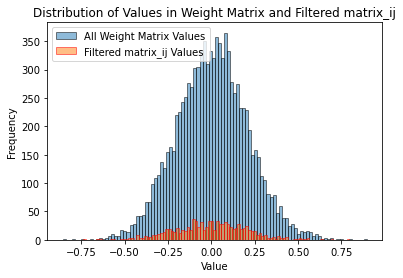

In [50]:
# Flatten the weight matrix to get all values
all_values = weight_matrix_df.values.flatten()

# Plot the distribution of all values in weight_matrix_df
plt.hist(all_values, bins=100, edgecolor='black', alpha=0.5, label='All Weight Matrix Values')

# Plot the distribution of matrix_ij values
plt.hist(matrix_ij, bins=100, edgecolor='red', alpha=0.5, label='Filtered matrix_ij Values')

# Labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values in Weight Matrix and Filtered matrix_ij')

# Add legend
plt.legend()

# Show plot
plt.show()

In [36]:
from scipy import stats
print(np.mean(matrix_ij))
print(np.median(matrix_ij))
print(np.max(matrix_ij))
print(np.min(matrix_ij))
print(np.ptp(matrix_ij))

-0.0047965045360663155
0.0004458790085
0.7945851
-0.7410992
1.5356843


In [40]:
count = 0
for element in matrix_ij:
    if element < 0.5 and element > -0.5:
        count += 1
        
print(f"percentage of true connections that lie within -0.5 to 0.5 is {(count/len(matrix_ij))*100}")
        
        

percentage of true connections that lie within -0.5 to 0.5 is 97.89473684210527
